Functions used for the plots

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import scipy
import pandas as pd
import seaborn as sns
import os

### FUNCTIONS

def LWC_cal(R, T_w, lwc, v_s, T_f, E, constants):

  C = constants['C']
  L = constants['L']
  k = C / L
  rho_i = constants['rho_i']
  Ts = constants['Ts']
  rho_w= 1000
  Ts = 273.15
  v_i=0.4*v_s
  rho_dry = v_i*rho_i/v_s
  #print('rho_dry is: {}'.format(rho_dry))
  v_w = v_s * lwc #[m3]

  M_s = rho_i*v_i + 1000*v_w
  M_w = M_s*R # kg
  rho_s = M_s/v_s
  v_w=v_s*lwc

  exp_params = {'M_s': M_s,
                'M_w': M_w}

  theta_w = M_s/(rho_w*v_s) * (1-C/L*((M_w+E)*(T_w-T_f)/M_s-(T_f-Ts)))

  return theta_w, exp_params;

def LWC_cal_Ms(R, T_w, M_s, T_f, E, constants):

  C = constants['C']
  L = constants['L']
  k = C / L
  rho_i = constants['rho_i']
  Ts = constants['Ts']
  rho_w= 1000
  v_i=0.4*v_s
  v_w = v_s * lwc #[m3]


  M_w = M_s*R # kg
  rho_s = M_s/v_s
  v_w=v_s*lwc

  exp_params = {'M_s': M_s,
                'M_w': M_w}

  theta_w = M_s/(rho_w*v_s) * (1-C/L*((M_w+E)*(T_w-T_f)/M_s-(T_f-Ts)))

  return theta_w;

def LWC_cal_Mw(M_w, T_w, M_s, T_f, E, constants):

  C = constants['C']
  L = constants['L']
  k = C / L
  rho_i = constants['rho_i']
  Ts = constants['Ts']
  rho_w= 1000

  v_i=0.4*v_s
  v_w = v_s * lwc #[m3]

  rho_s = M_s/v_s

  theta_w = M_s/(rho_w*v_s) * (1-C/L*((M_w+E)*(T_w-T_f)/M_s-(T_f-Ts)))

  return theta_w;


def find_Tf_melt(R, T_w, lwc, v_s, E, constants):

  C = constants['C']
  L = constants['L']
  k = C / L
  rho_i = constants['rho_i']
  Ts = constants['Ts']
  v_i = 0.4*v_s
  v_w = v_s * lwc #[m3]

  M_s = rho_i*v_i + 1000*v_w
  M_w = M_s*R # kg
  rho_s = M_s/v_s
  v_w=v_s*lwc

  print(rho_s)


  v_a = v_s - v_i - v_w

  T_f = ((rho_s/1000)*(k*((M_w+E)/M_s)*T_w+k*Ts-1) + lwc) / ((rho_s/1000)*k*(((M_w+E)/M_s)+1))

  return T_f;

def find_Tw_given_Tf(R, T_f, lwc, v_s, E, constants):

  C = constants['C']
  L = constants['L']
  k = C / L
  rho_i = constants['rho_i']
  Ts = constants['Ts']
  v_i = 0.4*v_s
  v_w = v_s * lwc #[m3]

  M_s = rho_i*v_i + 1000*v_w
  M_w = M_s*R # kg
  rho_s = M_s/v_s
  v_w=v_s*lwc

  a= rho_s*1e-3
  b = ((M_w+E)/M_s)

  T_w = ((T_f*(a*k*(b+1))-a*k*Ts+a-lwc)/(a*k*b)) - 273.15

  return T_w;




def sigma_theta_w_melting_calculator(R, T_w, E, lwc, v_s, sigma_Tf,constants, sigma_M = 0.0015):
  # Constants

  C = constants['C']
  L = constants['L']
  k = C / L
  rho_i = constants['rho_i']
  Ts = constants['Ts']
  v_w = v_s * lwc #[m3]
  v_i = 0.4*v_s

  rho_dry = v_i*rho_i/v_s
  #print('rho_dry is: {}'.format(rho_dry))

  M_s = rho_i*v_i + 1000*v_w
  M_w = M_s*R # kg
  rho_s = M_s/v_s
  #print(f'rho_s = {rho_s}')
  #print(f'M_s = {M_s}')
  #print(f'M_w = {M_w}')
  v_w=v_s*lwc


  v_a = v_s - v_i - v_w

  T_f = ((rho_s/1000)*(k*((M_w+E)/M_s)*T_w+k*Ts-1) + lwc) / ((rho_s/1000)*k*(((M_w+E)/M_s)+1))
  #print(f'T_f = {T_f-273.15}')

  ## Error propagation: derivatives

  d_M_w =  -rho_s*0.001*k*(T_w-T_f)/M_s
  d_T_w = -rho_s*0.001*k*(M_w+E)/M_s
  d_T_f = rho_s*0.001*k*((M_w+E)/M_s+1)
  d_M_s = M_s/(v_s*1000)*k*((M_w+E)*(T_w-T_f)/M_s**2)+(1-k*(((M_w+E)*(T_w-T_f)/M_s)-(T_f-Ts)))*1/(v_s*1000)
  d_V_s = -M_s/(v_s**2*1000)*(1-k*(((M_w+E)*(T_w-T_f)/M_s)-(T_f-Ts)))
  d_E = -rho_s*0.001*k*(T_w-T_f)/M_s



  # Measurement uncertainties
  sigma_Mw = sigma_M #[kg]
  sigma_Ms = sigma_M #[kg]
  # sigma_Mw = 0.0015 #[kg]
  # sigma_Ms = 0.0015 #[kg]
  sigma_Tw = 0.2 #[degC]
  sigma_v_s = 2 * 10**-6
  sigma_E = 0.0001


  derivatives = {'d_M_w':d_M_w,
                 'd_T_w':d_T_w,
                 'd_T_f':d_T_f,
                 'd_M_s':d_M_s,
                 'd_E':d_E}

  sigma_teta_w = np.sqrt(d_M_w**2 * sigma_Mw**2 + d_T_w**2 * sigma_Tw**2 +
                        d_T_f**2 * sigma_Tf**2 + d_M_s**2 * sigma_Ms**2+ d_V_s**2*sigma_v_s**2 + d_E**2*sigma_E**2)

  return sigma_teta_w, derivatives;

def sigma_theta_w_melting_calculator_fixed_mass(R, T_w, E, lwc, v_s, M_s, sigma_Tf):
  # Constants

  C = 4.186 * 1e3 # J Kg^-1 K^-1
  L = 3.34 * 1e5 # J Kg^-1
  Ci = 2.09 * 1e3  # J Kg^-1 K^-1
  Co = 1.83 * 1e3  # J Kg^-1 K^-1
  k = C / L
  rho_i = 917 # kg/dm^3
  Ts = 273.15

  M_w = M_s*R # kg
  rho_s = M_s/v_s

  T_f = ((rho_s/1000)*(k*((M_w+E)/M_s)*T_w+k*Ts-1) + lwc) / ((rho_s/1000)*k*(((M_w+E)/M_s)+1))

  ## Error propagation: derivatives

  d_M_w =  -rho_s*0.001*k*(T_w-T_f)/M_s
  d_T_w = -rho_s*0.001*k*(M_w+E)/M_s
  d_T_f = rho_s*0.001*k*((M_w+E)/M_s+1)
  d_M_s = M_s/(v_s*1000)*k*((M_w+E)*(T_w-T_f)/M_s**2)+(1-k*(((M_w+E)*(T_w-T_f)/M_s)-(T_f-Ts)))*1/(v_s*1000)
  d_V_s = -M_s/(v_s**2*1000)*(1-k*(((M_w+E)*(T_w-T_f)/M_s)-(T_f-Ts)))
  d_E = -rho_s*0.001*k*(T_w-T_f)/M_s

  # Measurement uncertainties
  sigma_Mw = 0.0001 #[kg]
  sigma_Ms = 0.0001 #[kg]
  sigma_Tw = 0.2 #[degC]
  sigma_v_s = 2 * 10**-6
  sigma_E = 0.0001

  derivatives = {'d_M_w':d_M_w,
                 'd_T_w':d_T_w,
                 'd_T_f':d_T_f,
                 'd_M_s':d_M_s,
                 'd_E':d_E}

  sigma_teta_w = np.sqrt(d_M_w**2 * sigma_Mw**2 + d_T_w**2 * sigma_Tw**2 +
                        d_T_f**2 * sigma_Tf**2 + d_M_s**2 * sigma_Ms**2+ d_V_s**2*sigma_v_s**2 + d_E**2*sigma_E**2)

  return sigma_teta_w, derivatives;

def sigma_theta_w_melting_calculator_GIAPPO(R, T_w, E, lwc, M_w, T_f, sigma_Tf, sigma_M = 0.0001):
  # Constants

  C = 4.186 * 1e3 # J Kg^-1 K^-1
  L = 3.34 * 1e5 # J Kg^-1
  Ci = 2.09 * 1e3  # J Kg^-1 K^-1
  k = C / L
  rho_i = 917 # kg/dm^3
  Ts = 273.15

  M_s = M_w/R # kg
  rho_s = M_s/v_s

  #T_f = ((rho_s/1000)*(k*((M_w+E)/M_s)*T_w+k*Ts-1) + lwc) / ((rho_s/1000)*k*(((M_w+E)/M_s)+1))

  ## Error propagation: derivatives

  d_M_w =  -k*(T_w-T_f)/M_s
  d_T_w = -k*(M_w+E)/M_s
  d_T_f = rho_s*0.001*k*((M_w+E)/M_s+1)
  d_M_s = k*((M_w+E)*(T_w-T_f)/M_s**2)+(1-k*(((M_w+E)*(T_w-T_f)/M_s)-(T_f-Ts)))
  d_V_s = -(1-k*(((M_w+E)*(T_w-T_f)/M_s)-(T_f-Ts)))
  d_E = -rho_s*0.001*k*(T_w-T_f)/M_s

  # Measurement uncertainties
  sigma_Mw = sigma_M #[kg]
  sigma_Ms = sigma_M #[kg]
  sigma_Tw = 0.1 #[degC]
  sigma_v_s = 2 * 10**-6


  derivatives = {'d_M_w':d_M_w,
                 'd_T_w':d_T_w,
                 'd_T_f':d_T_f,
                 'd_M_s':d_M_s,
                 'd_E':d_E}

  sigma_teta_w = np.sqrt(d_M_w**2 * sigma_Mw**2 + d_T_w**2 * sigma_Tw**2 +
                        d_T_f**2 * sigma_Tf**2 + d_M_s**2 * sigma_Ms**2)

  return sigma_teta_w, derivatives;


def sigma_theta_w_freezing_calculator(Rf, T_o, E_f, lwc, v_s, sigma_Tf_f,constants, sigma_M = 0.0001):
  # Constants

  C = constants['C']
  L = constants['L']
  k = C / L
  rho_i = constants['rho_i']
  Ts = constants['Ts']
  Ci = constants['Ci']
  Co = constants['Co']

  v_w = v_s * lwc #[m3]
  v_i = v_s * 0.4

  M_s = rho_i*v_i + 1000*v_w
  M_o = M_s * Rf
  rho_s = M_s/v_s
  v_w=v_s*lwc


  v_a = v_s - v_i - v_w


  T_f_f = (lwc*L*1000/rho_s+Rf*Co*T_o+Ci*Ts) / (Rf*Co+Ci)

  ## Error propagation: derivatives


  df_Mo = 0.001*rho_s*(Co*(T_f_f-T_o)/(L*M_s))
  df_Tf = 0.001*rho_s*(1/L)*((M_o+E)*Co/M_s + Ci)
  df_To = -0.001*rho_s*(M_o+E)*Co / (L*M_s)
  df_Ms = -(1/(L*v_s*1000))*(((M_o+E)*Co*(T_f_f-T_o))/(M_s)+(((M_o+E)*Co*(T_f_f-T_o))/M_s-Ci*(Ts-T_f_f)))
  df_Vs = -M_s/(v_s**2*1000)*((M_o+E)*Co*(T_f_f-T_o)/(L*M_s)-Ci*(Ts-T_f_f)/L)
  df_E = 0.001*rho_s*(Co*(T_f_f-T_o)/(L*M_s))

  df_E = 0.001*rho_s*(Co*(T_f_f-T_o)/(L*M_s))



  # Measurement uncertainties
  sigma_Mo = sigma_M #[kg]
  sigma_Ms = sigma_M #[kg]
  sigma_To = 0.2 #[degC]
  sigma_v_s = 2 * 10**-6
  sigma_E = 0.0001



  derivatives_frez = {'df_Mo':df_Mo,
                'df_Tf':df_Tf,
                'df_To':df_To,
                'df_Ms':df_Ms,
                'df_E':df_E}

  sigma_teta_w_freez = np.sqrt(df_Mo**2 * sigma_Mo**2 + df_To**2 * sigma_To**2 +
                      df_Tf**2 * sigma_Tf_f**2 + df_Ms**2 * sigma_Ms**2 + df_Vs**2*sigma_v_s**2+df_E**2*sigma_E**2)

  return sigma_teta_w_freez, derivatives_frez;

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here are defined the constants

In [4]:
# Constants
constants = {'C': 4.186 * 1e3,    # J Kg^-1 K^-1
             'L': 3.34 * 1e5,     # J Kg^-1
             'Ci': 2.09 * 1e3,    # J Kg^-1 K^-1
             'Co': 1.83 * 1e3,    # J Kg^-1 K^-1
             'rho_i': 917,        # kg/dm^3
             'Ts': 273.15}        # K



Fig.2 - Plot of $\sigma_{\theta_w^M}$ and $\sigma_{\theta_w^F}$ vs $\theta_w$ with instrumental error

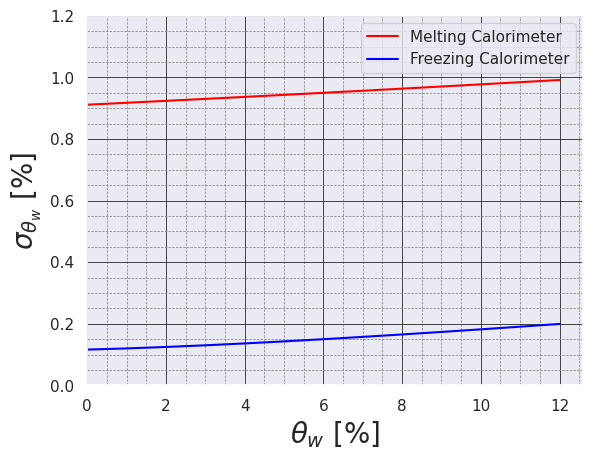

In [5]:
lwc = np.linspace(0, 0.12, 13)#[%]

# Melt
v_s = 200*10**-6 #[m3]
R=2
T_w = 40+273.14
E=6.58 * 10**-3
sigma_Tf = 0.2
#M_s = 100*10**-3 #kg

sigma_theta_melt = sigma_theta_w_melting_calculator(R, T_w, E, lwc, v_s, sigma_Tf, constants)[0]


# freez
Rf = 1.3
T_o = T1=-30 + 273.15
E_f=6.58 * 10**-3
sigma_Tf_f = 0.2
sigma_theta_freez = sigma_theta_w_freezing_calculator(Rf, T_o, E_f, lwc, v_s, sigma_Tf_f, constants)[0]

# Create a DataFrame with the data
data = {

        'LWC': lwc*100,
        'Melting Calorimeter Error': sigma_theta_melt*100,

        'Freezing Calorimeter Error': sigma_theta_freez*100
       }

df = pd.DataFrame(data)

y_min = 0
y_max = 1.2

# Set up the Seaborn style with grid and dashed secondary grid
sns.set(style="whitegrid", color_codes=True)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set(font_scale=1)

# Create the plot
sns.lineplot(data=df, x='LWC', y='Melting Calorimeter Error', label='Melting Calorimeter', color='red')
sns.lineplot(data=df, x='LWC', y='Freezing Calorimeter Error', label='Freezing Calorimeter', color='blue')

# Set the plot title and axes labels
#plt.title('LWC vs. Calorimeter Uncertainty')
plt.xlabel(r'$\theta_w$ [%]', fontsize=20)
plt.ylabel(r'$\sigma_{\theta_w}$ [%]', fontsize=20)

# Set the y-axis limits
plt.ylim(y_min, y_max)

# Add a legend
plt.legend()

# Set the x-axis to start from 0
plt.xlim(0, None)

# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
# Show the plot
plt.show()

**Fig**. 3a

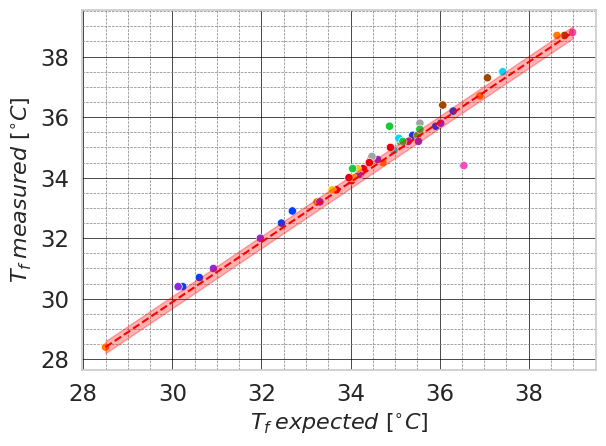

In [6]:
# Import Data
measures_sheet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab_Calorimetro_Density/uploads_for_paper/experiment_error_calorimeter.csv')

Ci = constants['Ci']
L = constants['L']
C = constants['C']

Wi = measures_sheet['Wi'].to_numpy()*10**-3
Ww = measures_sheet['Ww'].to_numpy()*10**-3

Ti = - 28.5
Tw = measures_sheet['Tw'].to_numpy()
Tf_measured = measures_sheet['Tf'].to_numpy()
names = measures_sheet['Name'].to_numpy()
operator = np.concatenate((np.ones(3), np.ones(3) * 2, np.ones(3) * 3, np.ones(3) * 4, np.ones(6) * 5))

# final temperature of the system
Tf = (Ci*Wi*Ti - L*Wi + C*(Ww+E)*Tw) / (C*(Ww+E) + Wi*C)

# Create a DataFrame from the data
data = {'Tf': Tf, 'Tf_measured': Tf_measured, 'names': names}
df_3 = pd.DataFrame(data)
sns.set(font_scale=1.5)
# Set up the plot
sns.set_style('whitegrid')
sns.scatterplot(x='Tf', y='Tf_measured', hue='names', data=df_3, palette='bright')
plt.xlabel(r'$T_f \: expected$ [$^{\circ}C$]', fontsize=16)
plt.ylabel(r'$T_f \: measured$ [$^{\circ}C$]', fontsize=16)

# Add 45-degree line
plt.plot([min(Tf), max(Tf)], [min(Tf_measured), max(Tf_measured)], color='red', linestyle='--')
# Add shaded buffer

# Calculate buffer size
buffer_size = 0.2  # Adjust this value as needed

# Add shaded buffer on both sides
plt.fill_between([min(Tf), max(Tf)], [min(Tf_measured)-buffer_size, max(Tf_measured)-buffer_size], [min(Tf_measured)+buffer_size, max(Tf_measured)+buffer_size], color='red', alpha=0.3, label='Uncertainty buffer')

# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.legend().remove()


plt.tight_layout()

Fig. 3b



THEORETICAL ERROR

The mean of the theoretical error is: 0.1813867521826959
The std of the theoretical error is: 0.007934552678655022
The RMSE of the theoretical error is: 0.18156021313491869


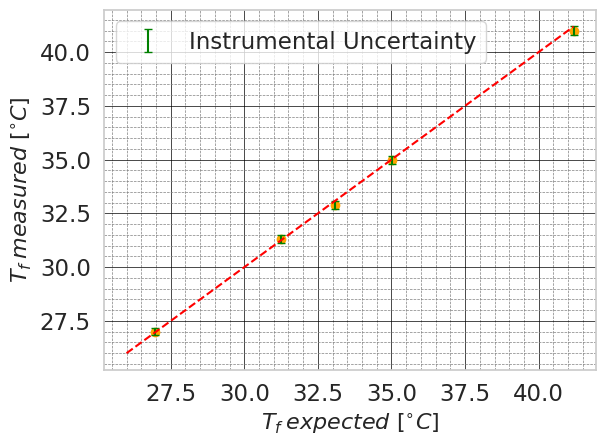

In [7]:
## Theoretical ERROR PROPAGATION
Tm = constants['Ts']
Mw = np.array([278.8, 299.8, 283.0, 313.5, 305.5]) * 10**-3
Tw = np.array([47.6, 48.7, 48.6, 48.2, 48.1]) + 273.15
Mi = np.array([14.5, 35.2, 38.6, 62.0, 46.3]) * 10**-3
Ti = np.array([-10.5, -8.5, -7.3,-5.9, -5]) + 273.15
#Ti = np.array([-50, -50, -50]) + 273.15
T_f_meas = np.array([41.0, 35.0, 32.9, 27, 31.3])

Tf = (Mi*Ci*(Ti-Tm) + Tw*C*(Mw+E)+Mi*C*Tm-L*Mi) / (C*(Mw+E+Mi))- 273.15


sigma_Mi = 0.0001 #[g]
sigma_Ti = 0.2 #[K]
sigma_Tw = 0.2 #[K]
sigma_Mw = 0.0001 #[g]

Tf = (Mi*Ci*(Ti-Tm) + Tw*C*(Mw+E)+Mi*C*Tm-L*Mi) / (C*(Mw+E+Mi))- 273.15

#pd_Mi = (Ci*(Ti-L*Tm)*(Mw+E+Mi)-(Mi*Ci*Ti+Tw*C*(Mw+E)-L*Mi))/(C*(Mw+E+Mi)**2)
pd_Mi = ((Mw+E)*(Ci*(Ti-Tm)+C*Tm-L-Tw*C)) / (C*(Mw+E+Mi)**2)

pd_Ti = (Mi*Ci) / (C*(Mw+E+Mi))

pd_Tw = (Mw+E) / (Mw+E+Mi)


pd_Mw = (Mi*(Tw*C-Ci*(Ti-Tm)-C*Tm+L))/(C*(Mw+E+Mi)**2)

sigma_Tf = np.sqrt(pd_Mi**2*sigma_Mi**2+pd_Ti**2*sigma_Ti**2+pd_Tw**2*sigma_Tw**2+pd_Mw**2*sigma_Mw**2)


print('\n\nTHEORETICAL ERROR\n')
print('The mean of the theoretical error is: {}'.format(np.mean(sigma_Tf)))
print('The std of the theoretical error is: {}'.format(np.std(sigma_Tf)))
print('The RMSE of the theoretical error is: {}'.format(np.sqrt(np.mean((sigma_Tf)**2))))



plt.scatter(Tf, T_f_meas, color='orange')
#plt.scatter(Tf_no_E, T_f_meas)
plt.xlabel(r'$T_f \: expected$ [$^{\circ}C$]', fontsize=16)
plt.ylabel(r'$T_f \: measured$ [$^{\circ}C$]', fontsize=16)

# Add error bars for uncertainty
plt.errorbar(Tf, T_f_meas, yerr=sigma_Tf, fmt='none', ecolor='green', capsize=3, label='Instrumental Uncertainty')

# Add 45 degree line
max_val = max(Tf.max(), T_f_meas.max())
min_val = max(Tf.min(), T_f_meas.min())
plt.plot([min_val-1, max_val], [min_val-1, max_val], color='red', linestyle='--')
plt.legend()
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.tight_layout()


Fig. 4 Plot of $\sigma_{\theta_w^M}$ and $\sigma_{\theta_w^M}$ with updated error

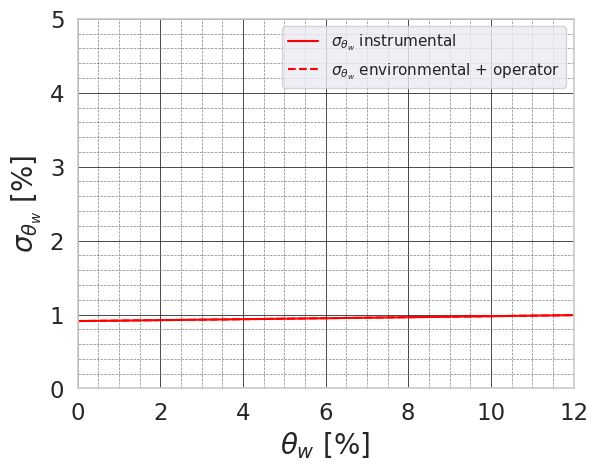

In [8]:
# Melting

sigma_Tf = 0.2
sigma_theta_melt_updated = sigma_theta_w_melting_calculator(R, T_w, E, lwc, v_s, sigma_Tf,constants)[0]

df['Melting Calorimeter Error Updated'] = sigma_theta_melt_updated*100

# Create the plot
sns.lineplot(data=df, x='LWC', y='Melting Calorimeter Error', label=r'$\sigma_{\theta_w}$ instrumental', color='red')
sns.lineplot(data=df, x='LWC', y='Melting Calorimeter Error Updated',
             label=r'$\sigma_{\theta_w}$ environmental + operator', color='red',linestyle='--')
sns.set(font_scale=1)


# Set the plot title and axes labels
#plt.title('LWC vs. Calorimeter Uncertainty')
plt.xlabel(r'$\theta_w$ [%]', fontsize=20)
plt.ylabel(r'$\sigma_{\theta_w}$ [%]', fontsize=20)
# Set the y-axis limits
plt.ylim(y_min, y_max)
plt.ylim(y_min, 5)
# Set the x-axis to start from 0
plt.xlim(0, 12)

# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

# Add a legend
plt.legend()

# Show the plot
plt.show()

Fig. 5

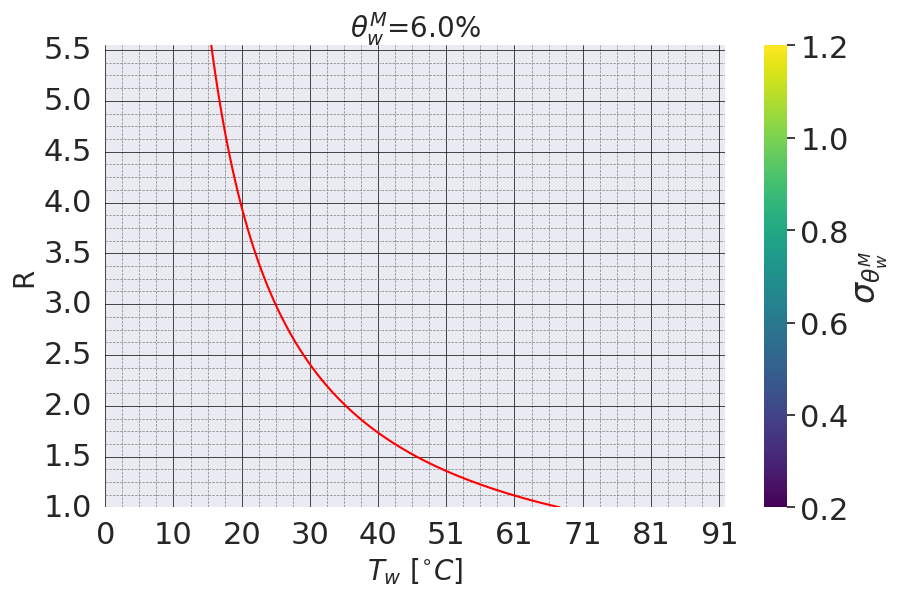

In [9]:
# Melting Calorimeter parameters
v_s = 200*10**-6
#R_list = np.flip(np.linspace(1, 6, 100))
R_list = np.linspace(1, 6, 100)
T_w_list = np.linspace(0, 100, 100) + 273.15
Ts = constants['Ts']
sigma_Tf = 0.2 #[degC]
# Sample parameters and other parameters
lwc = 0.06 # [%]


# Initialize data for the plot
final_img = np.zeros((len(R_list), len(T_w_list)))
# Initialize data for the plot
final_img_deltaT = np.zeros((len(R_list), len(T_w_list)))


T_f_safe = 5 + 273.15

safe_Tw_limit = find_Tw_given_Tf(R_list, T_f_safe, lwc, v_s, E, constants)


for i in range(len(R_list)):
  for j in range(len(T_w_list)):

    R = R_list[i]
    T_w = T_w_list[j]


    T_f_m = find_Tf_melt(R, T_w, lwc, v_s, E, constants)

    delta_T = T_w - T_f_m

    if T_f_m <= 273.15:
      final_img[i,j] = 255


    else:


      sigma_teta_w = sigma_theta_w_melting_calculator(R, T_w, E, lwc, v_s, sigma_Tf, constants)[0]


      final_img[i,j] = sigma_teta_w*100
      final_img_deltaT[i,j] = delta_T


# Create lists of R and T_w values
r_values = np.around(R_list, decimals=1)
tw_values = np.around(T_w_list - 273.15, decimals=0)
# Create a DataFrame from the final_img array
df = pd.DataFrame(final_img)
df_blank = pd.DataFrame(final_img)
# Set the value 255 to NaN (so it will be displayed as black)

df_blank[df_blank > 0] = np.nan
df[df == 255] = np.nan



e_min = 0.2
e_max = 1.2

plt.figure(figsize=(10, 6))

sns.set(font_scale=2)


ax=sns.heatmap(df_blank, cmap="viridis", cbar_kws={'label': r'$\sigma_{\theta_w^M} %$'},
            xticklabels='auto', yticklabels='auto', vmin=e_min, vmax=e_max)  # Set vmin and vmax
ax.axes.invert_yaxis()

# Define the new range (0 to 100)
new_min = 0
new_max = 100

# Find the minimum and maximum values in the original array
min_value = np.min(R_list)
max_value = np.max(R_list)


# Rescale the array to the new range
rescaled_R_array = ((R_list - min_value) / (max_value - min_value)) * (new_max - new_min) + new_min


sns.lineplot(x=safe_Tw_limit, y=rescaled_R_array, color='red', ax=ax)

plt.title(r'$\theta_w^M$={}%'.format(lwc*100), fontsize=20)
plt.xlabel(r'$T_w$ [$^{\circ}C$]', fontsize=20)
plt.ylabel('R', fontsize=20)
plt.xticks(np.linspace(0, len(T_w_list)-1, 10), map(int, tw_values[::10]), rotation=0)
plt.yticks(np.linspace(0, len(R_list)-1, 10), r_values[::10])

# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

0.9084060133370465
1.7886363986454517


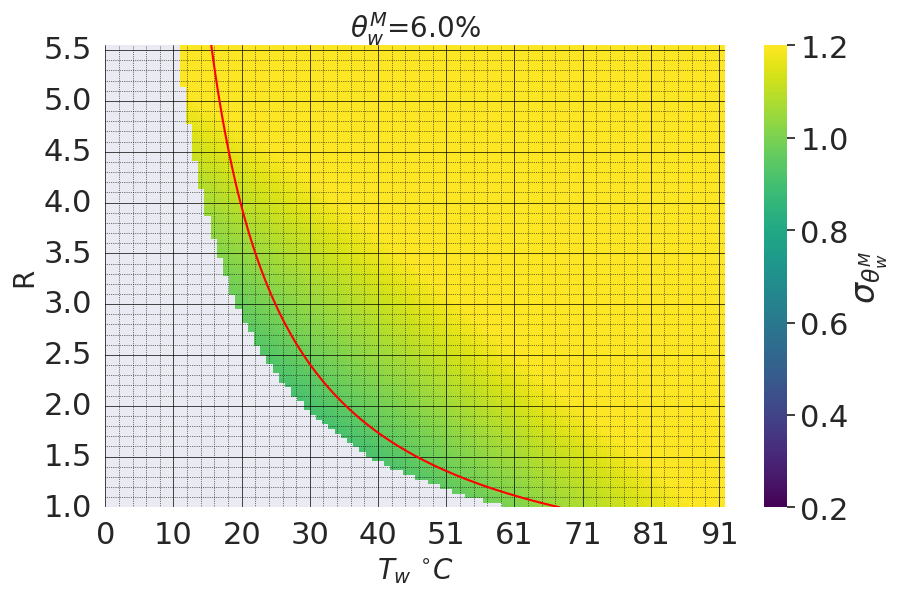

In [10]:
# Melting Calorimeter parameters
v_s = 200*10**-6
#R_list = np.flip(np.linspace(1, 6, 100))
R_list = np.linspace(1, 6, 100)
T_w_list = np.linspace(0, 100, 100) + 273.15
Ts = constants['Ts']
sigma_Tf = 0.2 #[degC]
# Sample parameters and other parameters
lwc = 0.06 # [%]
# Initialize data for the plot
final_img = np.zeros((len(R_list), len(T_w_list)))
# Initialize data for the plot
final_img_deltaT = np.zeros((len(R_list), len(T_w_list)))


T_f_safe = 5 + 273.15

safe_Tw_limit = find_Tw_given_Tf(R_list, T_f_safe, lwc, v_s, E, constants)


for i in range(len(R_list)):
  for j in range(len(T_w_list)):

    R = R_list[i]
    T_w = T_w_list[j]


    T_f_m = find_Tf_melt(R, T_w, lwc, v_s, E, constants)

    delta_T = T_w - T_f_m

    if T_f_m <= 273.15:
      final_img[i,j] = 255


    else:


      sigma_teta_w = sigma_theta_w_melting_calculator(R, T_w, E, lwc, v_s, sigma_Tf, constants)[0]


      final_img[i,j] = sigma_teta_w*100
      final_img_deltaT[i,j] = delta_T


# Create lists of R and T_w values
r_values = np.around(R_list, decimals=1)
tw_values = np.around(T_w_list - 273.15, decimals=0)
# Create a DataFrame from the final_img array
df = pd.DataFrame(final_img)

# Set the value 255 to NaN (so it will be displayed as black)
df[df == 255] = np.nan



print(np.min(final_img[np.logical_not(np.isnan(final_img))]))
print(np.max(final_img[np.logical_not(np.isnan(final_img))]))

e_min = 0.2
e_max = 1.2

plt.figure(figsize=(10, 6))

sns.set(font_scale=2)

#ax.plot(x, y, zorder=1)  # Set z-order to 1

ax=sns.heatmap(df, cmap="viridis", cbar_kws={'label': r'$\sigma_{\theta_w^M} %$'},
            xticklabels='auto', yticklabels='auto', vmin=e_min, vmax=e_max,zorder=0)  # Set vmin and vmax
ax.axes.invert_yaxis()


# Define the new range (0 to 100)
new_min = 0
new_max = 100

# Find the minimum and maximum values in the original array
min_value = np.min(R_list)
max_value = np.max(R_list)


# Rescale the array to the new range
rescaled_R_array = ((R_list - min_value) / (max_value - min_value)) * (new_max - new_min) + new_min


sns.lineplot(x=safe_Tw_limit, y=rescaled_R_array, color='red', ax=ax,zorder=5)

#plt.title(r'Ms={}g - $\theta_w^M$={}% - E={}g'.format(round(M_s*1000, 2), lwc*100, E*1000))

# Set xlim and ylim
plt.title(r'$\theta_w^M$={}%'.format(lwc*100), fontsize=20)
plt.xlabel(r'$T_w$ $^{\circ}C$', fontsize=20)
plt.ylabel('R', fontsize=20)
plt.xticks(np.linspace(0, len(T_w_list)-1, 10), map(int, tw_values[::10]), rotation=0)
plt.yticks(np.linspace(0, len(R_list)-1, 10), r_values[::10])
plt.yticks(np.linspace(0, len(R_list)-1, 46), minor=True)  # Minor ticks every 0.1 unit
plt.xticks(np.linspace(0, len(T_w_list)-1, 46), minor=True)  # Minor ticks every 0.1 unit
sns.set_style("whitegrid", {'axes.grid' : False})

ax.grid(which='both')#, zorder=3)  # Apply grid to both major and minor ticks

# Set grid lines style
ax.grid(which='major', color='black', linestyle='-', linewidth=0.5,zorder=3)  # Major grid lines
ax.grid(which='minor', color='black', linestyle=':', linewidth=0.5,zorder=4)  # Minor grid lines

# Remove top and right spines
#sns.despine()




Fig. 6a Error $\theta_w^M$ vs $V_s$

416.8
[416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8
 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8
 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8
 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8
 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8
 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8
 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8
 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8 416.8
 416.8 416.8 416.8 416.8]


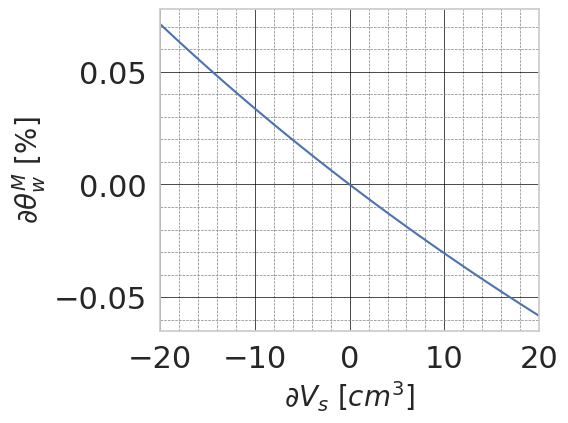

In [18]:
lwc = 0.05
v_s_real = 200*10**-6
v_s = np.linspace(v_s_real-20*10**-6, v_s_real+20*10**-6, 100)

T_f_real = find_Tf_melt(R, T_w, lwc, v_s_real, E, constants)

T_f=find_Tf_melt(R, T_w, lwc, v_s, E, constants)
theta_w= LWC_cal(R, T_w, lwc, v_s, T_f, E, constants)[0]
theta_w_real, exp_params = LWC_cal(R, T_w, lwc, v_s, T_f_real, E, constants)
M_s=exp_params['M_s']
M_w=exp_params['M_w']
theta_w[theta_w<0]=0

plt.plot((v_s - v_s_real)*10**6, (theta_w - theta_w_real)*100)
plt.xlim(min((v_s - v_s_real)*10**6), max((v_s - v_s_real)*10**6))
#plt.title(r'Ms={}$g$ - Mw={}g - Tf={}$^\circ$C - E={}g - $\theta_w^M$={}'.format(round(M_s*10**3, 2), round(M_w*1000,1), round(T_f_real-273.15,1), E_real*1000, round(theta_w_real*100, 2)))
plt.xlabel(r'$\partial V_s$ [$cm^3$]', fontsize=20)
plt.ylabel(r'$\partial \theta_w^M $ [%]', fontsize=20)
# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

# Adjust layout before saving
plt.tight_layout()

Fig. 6b Error $\theta_w^M$ vs $M_w$

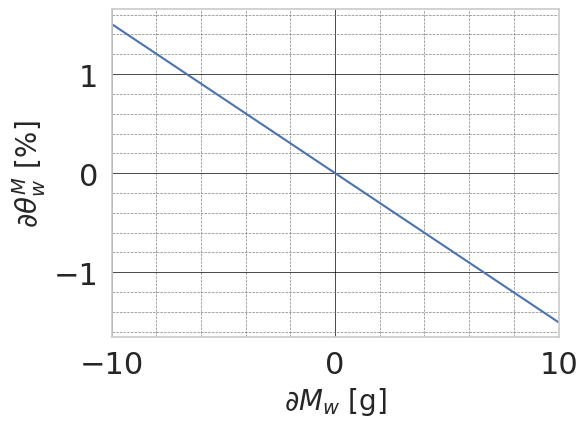

In [12]:
v_s = 200*10**-6 #[m3]
lwc = 0.05
rho_i = constants['rho_i']
v_w = v_s * lwc #[m3]
v_i = 0.4*v_s
M_s = rho_i*v_i + 1000*v_w
M_w_real = M_s*R
M_w = np.linspace(M_w_real-0.01, M_w_real+0.01, 100)

T_f_real = find_Tf_melt(R, T_w, lwc, v_s, E, constants)


theta_w= LWC_cal_Mw(M_w, T_w, M_s, T_f_real, E, constants)
theta_w_real = LWC_cal_Mw(M_w_real, T_w, M_s, T_f_real, E, constants)
theta_w[theta_w<0]=0

plt.plot((M_w-M_w_real)*1000, (theta_w - theta_w_real)*100)
plt.xlim(min((M_w-M_w_real)*1000), max((M_w-M_w_real)*1000))
#plt.title(r'Ms={}$g$ - Mw={}g - Tf={}$^\circ$C - E={}g - $\theta_w^M$={}'.format(round(M_s*10**3, 2), round(M_w*1000,1), round(T_f_real-273.15,1), E_real*1000, round(theta_w_real*100, 2)))
plt.xlabel(r'$ \partial M_w$ [g]', fontsize=20)
plt.ylabel(r'$\partial \theta_w^M $ [%]', fontsize=20)


# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
# Adjust layout before saving
plt.tight_layout()

Fig. 6c Error $\theta_w^M$ vs $T_w$

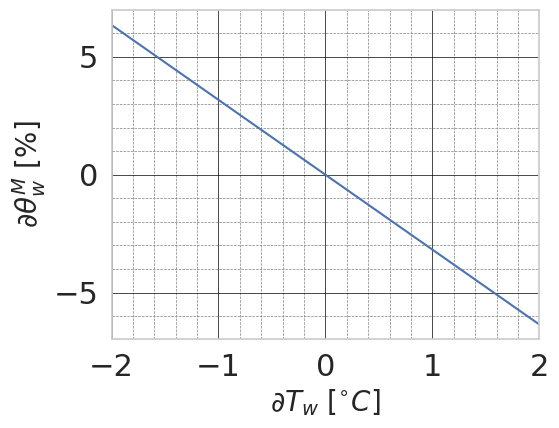

In [13]:
lwc = 0.05
T_w_real = 40+273.13
T_w_mod = np.linspace(T_w_real-2, T_w_real+2, 100)

T_f_real = find_Tf_melt(R, T_w_mod, lwc, v_s, E, constants)

theta_w= LWC_cal(R, T_w_mod, lwc, v_s, T_f_real, E, constants)[0]
theta_w_real, exp_params = LWC_cal(R, T_w_real, lwc, v_s, T_f_real, E, constants)
M_s=exp_params['M_s']
M_w=exp_params['M_w']
theta_w[theta_w<0]=0

plt.plot((T_w_mod-T_w_real), (theta_w - theta_w_real)*100)
plt.xlim(min((T_w_mod-T_w_real)), max((T_w_mod-T_w_real)))
#plt.title(r'Ms={}$g$ - Mw={}g - Tf={}$^\circ$C - E={}g - $\theta_w^M$={}'.format(round(M_s*10**3, 2), round(M_w*1000,1), round(T_f_real-273.15,1), E_real*1000, round(theta_w_real*100, 2)))
plt.xlabel(r'$ \partial T_w$ [$^{\circ}C$]', fontsize=20)
plt.ylabel(r'$\partial \theta_w^M $ [%]', fontsize=20)

# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
# Adjust layout before saving
plt.tight_layout()

Fig. 6d Error $\theta_w^M$ vs $T_f$

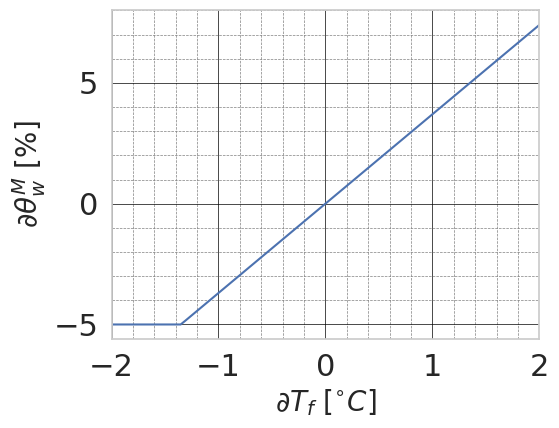

In [14]:
lwc = 0.05
T_w = 40+273.13

T_f_real = find_Tf_melt(R, T_w, lwc, v_s, E, constants)

T_f=np.linspace(T_f_real-2, T_f_real+2, 100)
theta_w= LWC_cal(R, T_w, lwc, v_s, T_f, E, constants)[0]
theta_w_real, exp_params = LWC_cal(R, T_w, lwc, v_s, T_f_real, E, constants)
M_s=exp_params['M_s']
M_w=exp_params['M_w']
theta_w[theta_w<0]=0

plt.plot(T_f - T_f_real, (theta_w - theta_w_real)*100)
plt.xlim(min(T_f - T_f_real), max(T_f - T_f_real))
#plt.title(r'Ms={}$g$ - Mw={}g - Tf={}$^\circ$C - E={}g - $\theta_w^M$={}'.format(round(M_s*10**3, 2), round(M_w*1000,1), round(T_f_real-273.15,1), E_real*1000, round(theta_w_real*100, 2)))
plt.xlabel(r'$\partial T_f$ [$^{\circ}C$]', fontsize=20)
plt.ylabel(r'$\partial \theta_w^M $ [%]', fontsize=20)

# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
# Adjust layout before saving
plt.tight_layout()

Fig. 6e Error $\theta_w^M$ vs $M_s$

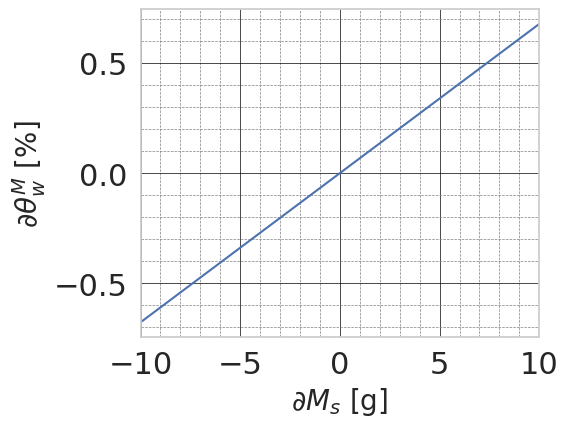

In [15]:
lwc = 0.05
v_w = v_s * lwc #[m3]

M_s_real = rho_i*v_i + 1000*v_w

M_s = np.linspace(M_s_real-0.01, M_s_real+0.01, 100)

T_f_real = find_Tf_melt(R, T_w, lwc, v_s, E, constants)


theta_w= LWC_cal_Ms(R, T_w, M_s, T_f_real, E, constants)
theta_w_real = LWC_cal_Ms(R, T_w, M_s_real, T_f_real, E, constants)
theta_w[theta_w<0]=0

plt.plot((M_s-M_s_real)*1000, (theta_w - theta_w_real)*100)
plt.xlim(min((M_s-M_s_real)*1000), max((M_s-M_s_real)*1000))

plt.xlabel(r'$ \partial M_s$ [g]', fontsize=20)
plt.ylabel(r'$\partial \theta_w^M $ [%]', fontsize=20)


# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
# Adjust layout before saving
plt.tight_layout()


Fig. 6e Error $\theta_w^M$ vs E

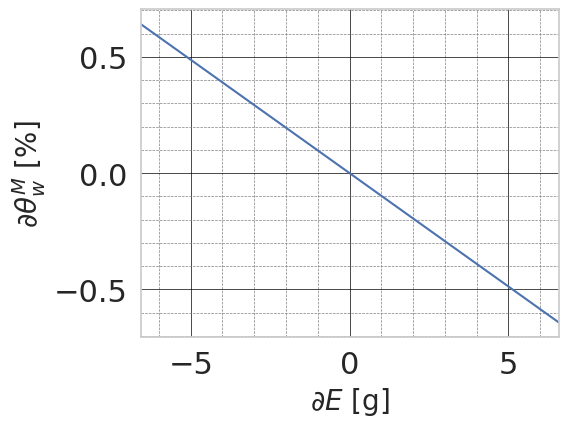

In [16]:
lwc = 0.05

E_real = 6.58 * 10**-3
E_mod = np.linspace(E_real-E_real, E_real*2, 100) # kg

T_f_real = find_Tf_melt(R, T_w, lwc, v_s, E_real, constants)


theta_w= LWC_cal(R, T_w, lwc, v_s, T_f_real, E_mod, constants)[0]
theta_w_real, exp_params = LWC_cal(R, T_w, lwc, v_s, T_f_real, E_real, constants)
M_s=exp_params['M_s']
M_w=exp_params['M_w']
theta_w[theta_w<0]=0

plt.plot((E_mod-E_real)*1000, (theta_w - theta_w_real)*100)

plt.xlabel(r'$ \partial E$ [g]', fontsize=20)
plt.ylabel(r'$\partial \theta_w^M $ [%]', fontsize=20)


# Add a secondary grid using Matplotlib
plt.grid(linewidth='0.5', color='black')
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.xlim(min((E_mod-E_real)*1000), max((E_mod-E_real)*1000))
#print('The derivative dtheta/dE in the point defined by \nMs={}g - Mw={}g - Tw={}degC is {}'.format(round(M_s*1000, 2), M_w*1000, round(T_w-273.15,1), dtheta_E))
# Adjust layout before saving
plt.tight_layout()
